In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:

# Set a random seed for reproducibility
np.random.seed(42)

# Load the dataset using the full path
data = pd.read_csv('/Users/danieldominguez/Desktop/riceai_project2_team8/raw_data/usa-housing-dataset/usa_housing_kaggle.csv')

# first few rows of the dataset
print("First 5 rows of the dataset:")
display(data.head())

# missing values
print("\nMissing values in each column:")
print(data.isnull().sum())



First 5 rows of the dataset:


,Price,Bedrooms,Bathrooms,SquareFeet,YearBuilt,GarageSpaces,LotSize,ZipCode,CrimeRate,SchoolRating
0,221958,1,1.9,4827,1979,2,1.45,82240,48.60,5
1,771155,2,2.0,1035,1987,2,1.75,74315,92.03,9
2,231932,1,3.0,2769,1982,1,1.46,79249,52.08,3
3,465838,3,3.3,2708,1907,3,1.62,80587,61.65,1
4,359178,4,3.4,1175,1994,2,0.74,20756,15.66,4



Missing values in each column:
Price           0
Bedrooms        0
Bathrooms       0
SquareFeet      0
YearBuilt       0
GarageSpaces    0
LotSize         0
ZipCode         0
CrimeRate       0
SchoolRating    0
dtype: int64


In [9]:
# missing values (e.g., using the median for numerical columns)
for col in ['Price', 'Bedrooms', 'Bathrooms', 'SqFt', 'YearBuilt', 'GarageSpace', 'LotSize', 'CrimeRate', 'SchoolRating']:
    if col in data.columns and data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

# categorical columns (e.g., Zipcode), we can fill with the mode
if 'Zipcode' in data.columns and data['Zipcode'].isnull().sum() > 0:
    data['Zipcode'].fillna(data['Zipcode'].mode()[0], inplace=True)

# Verify missing values are handled
print("\nMissing values after cleaning:")
print(data.isnull().sum())


Missing values after cleaning:
Price           0
Bedrooms        0
Bathrooms       0
SquareFeet      0
YearBuilt       0
GarageSpaces    0
LotSize         0
ZipCode         0
CrimeRate       0
SchoolRating    0
dtype: int64


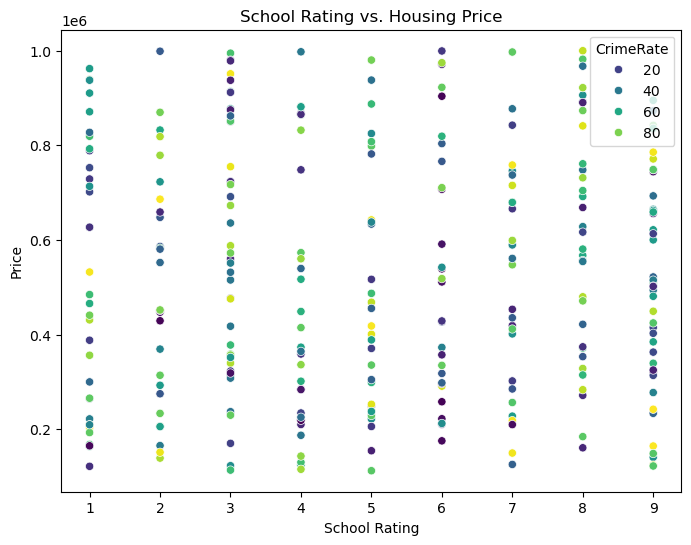

In [10]:
# --- Feature Engineering & Exploratory Data Analysis (EDA) ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='SchoolRating', y='Price', hue='CrimeRate', palette='viridis')
plt.title('School Rating vs. Housing Price')
plt.xlabel('School Rating')
plt.ylabel('Price')
plt.show()

In [23]:
# --- Prepare Data for Modeling ---
# feature columns and target using the correct column names
feature_cols = ['Bedrooms', 'Bathrooms', 'SquareFeet', 'YearBuilt', 'GarageSpaces', 'LotSize', 'ZipCode', 'CrimeRate', 'SchoolRating']
target = 'Price'

X = data[feature_cols]
y = data[target]

# Convert 'ZipCode' to string (to treat it as a categorical feature)
X['ZipCode'] = X['ZipCode'].astype(str)

# Identify categorical and numerical columns
categorical_features = ['ZipCode']
numerical_features = [col for col in feature_cols if col not in categorical_features]

# column transformer to handle different types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

/var/folders/6n/55l34wxj6nsdn_ws1wxqlpzr0000gn/T/ipykernel_17725/1502894524.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ZipCode'] = X['ZipCode'].astype(str)


In [24]:
# --- Modeling Pipeline ---
# We'll use a Random Forest Regressor for this example
model = RandomForestRegressor(random_state=42)

# pipeline that first transforms the data then fits the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Model Training ---
pipeline.fit(X_train, y_train)

# --- Model Evaluation ---
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("\nModel Performance:")
print(f"R-squared: {r2:.3f}")




Model Performance:
R-squared: -0.161


In [25]:
# --- Modeling Pipeline with GridSearchCV ---
from sklearn.model_selection import GridSearchCV


In [26]:
# Define our base model (without tuning)
base_model = RandomForestRegressor(random_state=42)

In [27]:
# Create the pipeline as before
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', base_model)
])

In [28]:
# Define the hyperparameter grid for the RandomForestRegressor.
# Feel free to adjust these values or add more parameters!
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

In [29]:
# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

In [30]:
# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters:
{'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}


In [31]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)

print("\nModel Performance after Hyperparameter Tuning:")
print(f"R-squared: {r2_best:.3f}")


Model Performance after Hyperparameter Tuning:
R-squared: -0.110


In [32]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# 1. Create a new feature 'HouseAge'
current_year = datetime.datetime.now().year
data['HouseAge'] = current_year - data['YearBuilt']

# Let's check the first few rows to confirm the new feature
print(data[['YearBuilt', 'HouseAge']].head())

   YearBuilt  HouseAge
0       1979        46
1       1987        38
2       1982        43
3       1907       118
4       1994        31


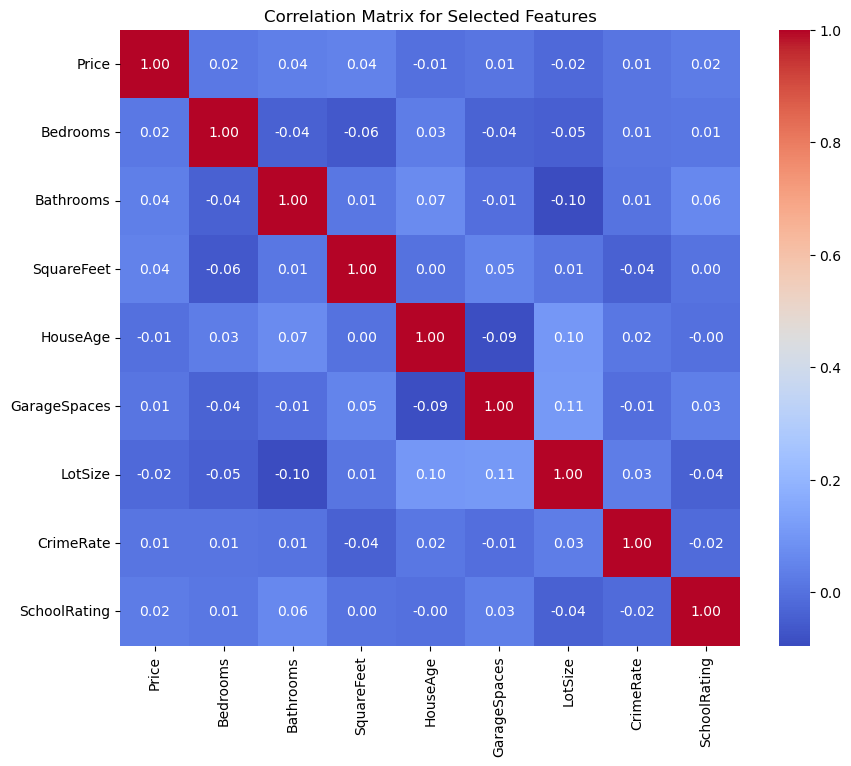

In [34]:
# 2. Compute and visualize the correlation matrix
# Select a subset of columns including our new feature and target
corr_features = ['Price', 'Bedrooms', 'Bathrooms', 'SquareFeet', 'HouseAge', 'GarageSpaces', 'LotSize', 'CrimeRate', 'SchoolRating']
corr_matrix = data[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Selected Features')
plt.show()

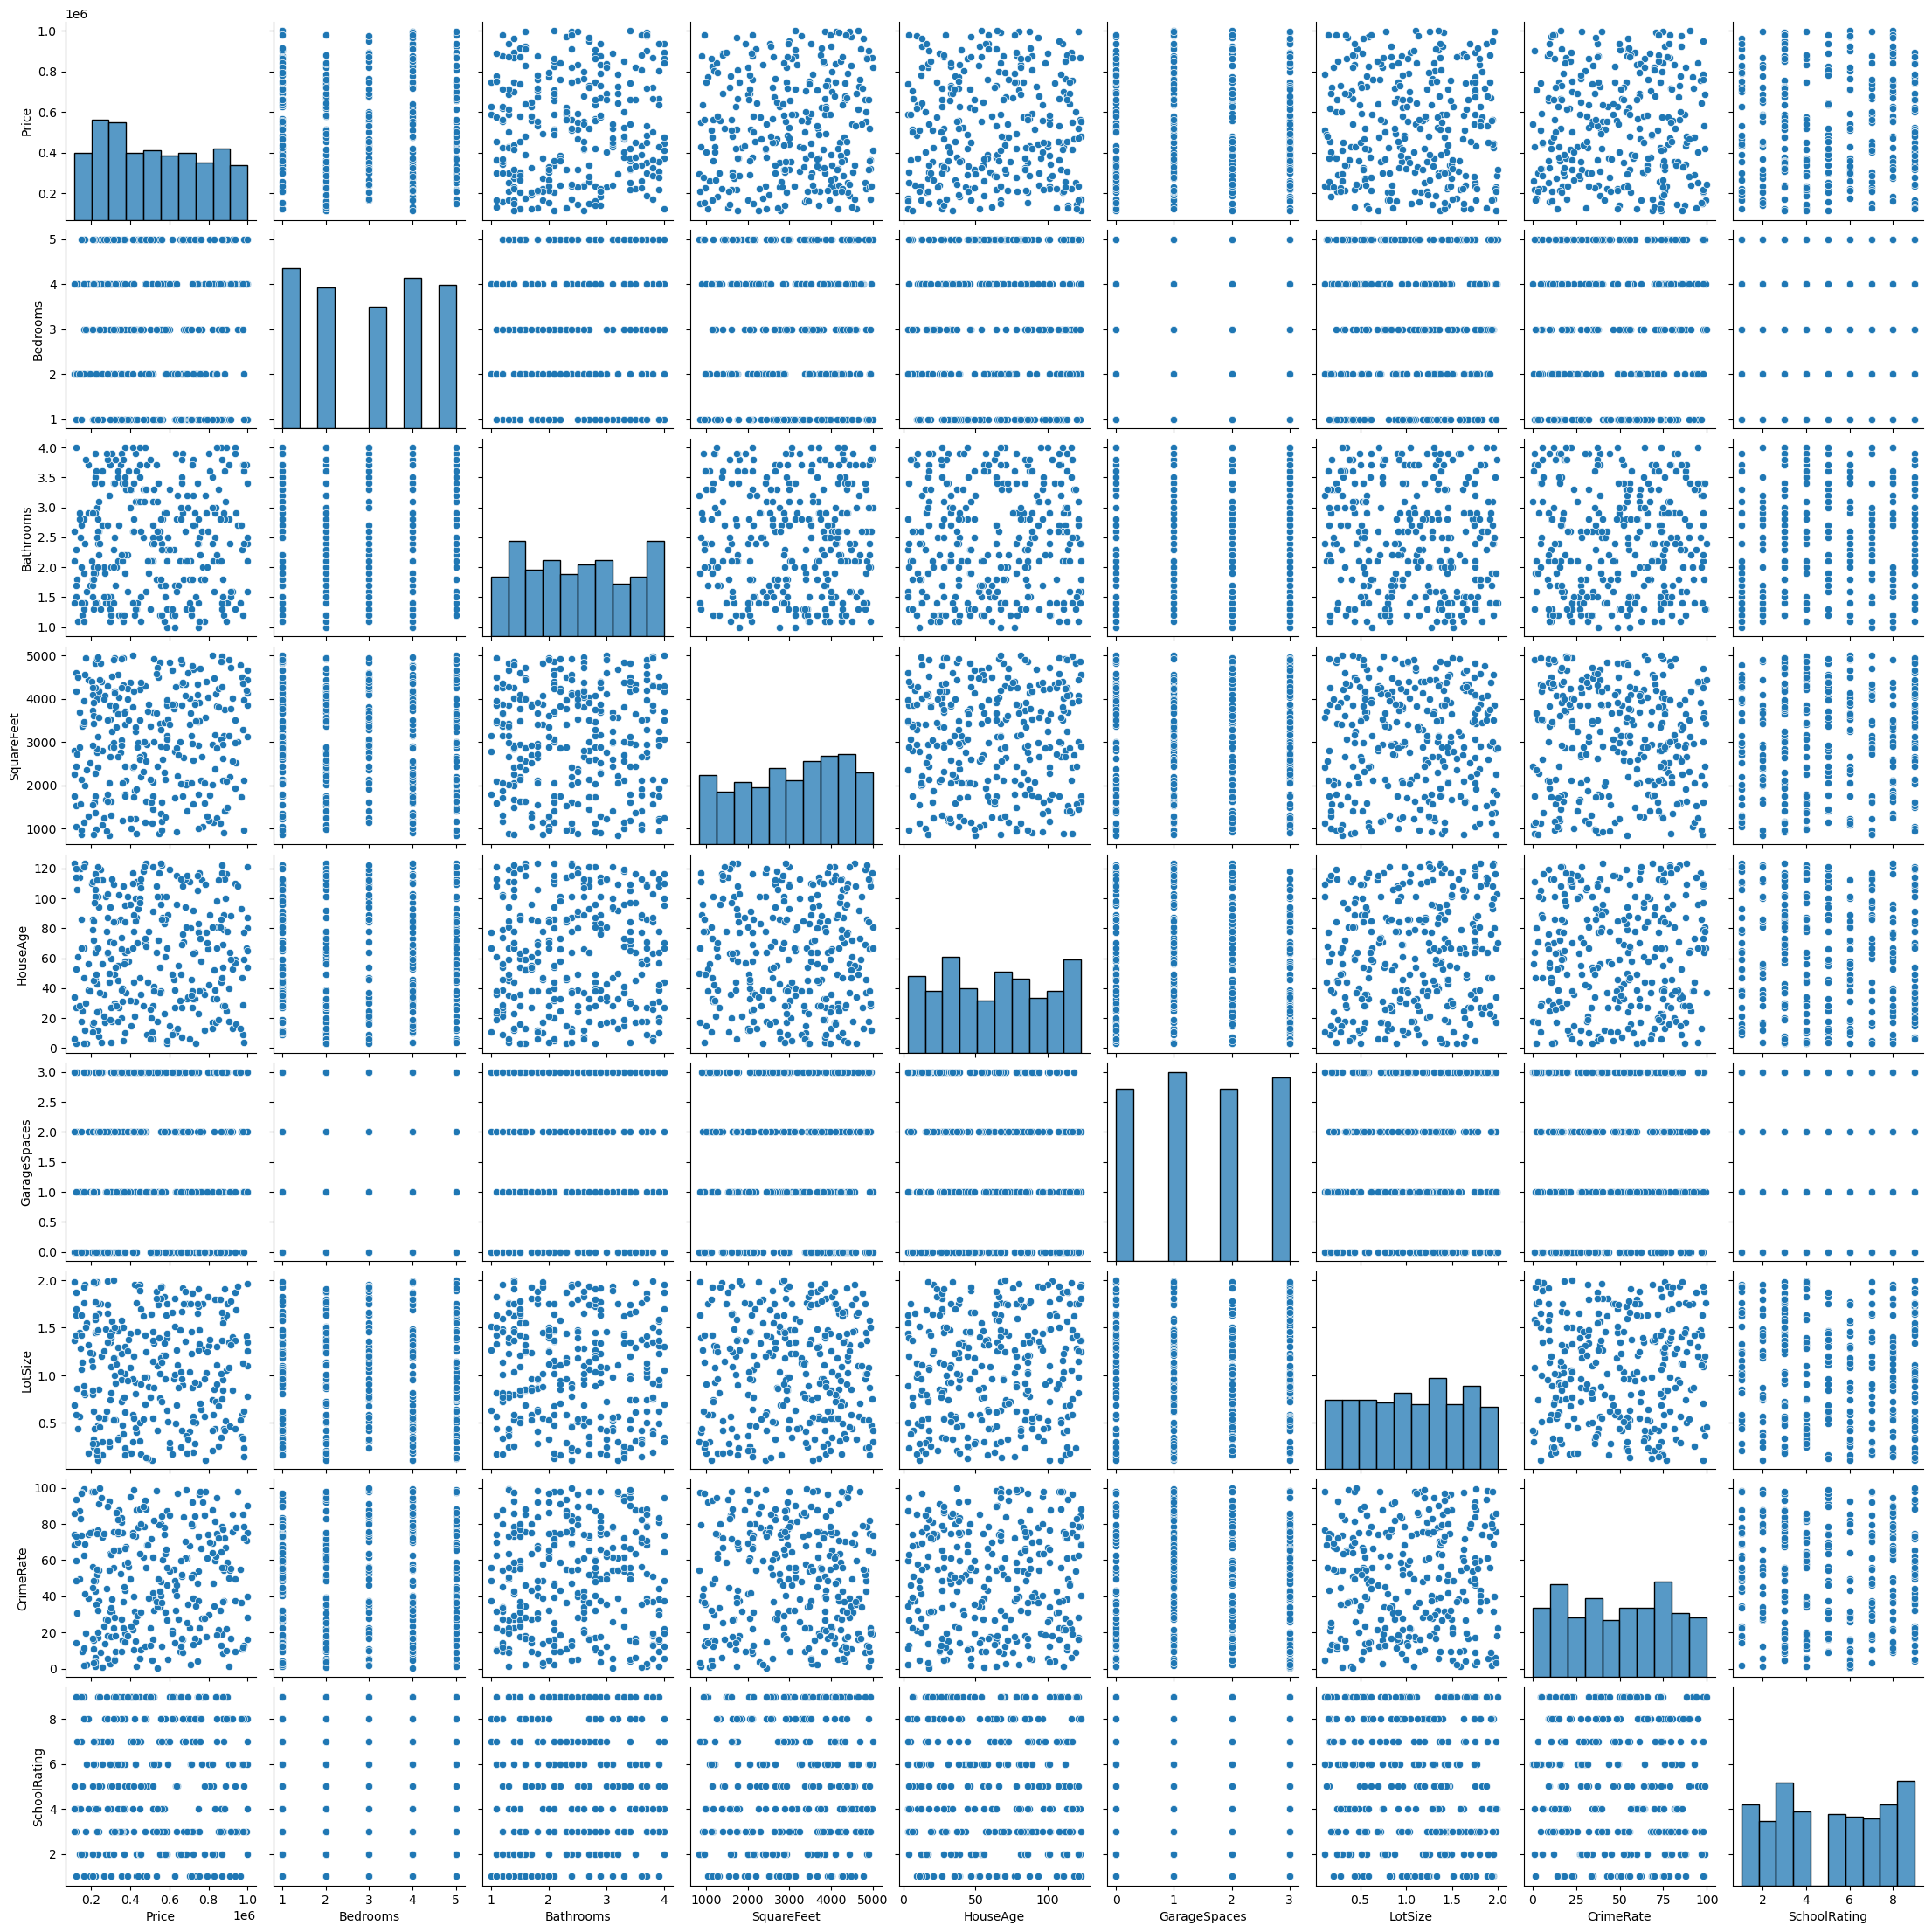

In [35]:
# 3. Plot pairwise relationships for key features
# This can give us an idea of the relationships between variables visually
sns.pairplot(data[corr_features])
plt.show()